In [1]:
# Main notebook for breakthrough infections
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)
import seaborn as sns
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
from matplotlib import cm # Colormaps
import matplotlib.ticker as mtick

#%matplotlib widget
# plt.rcParams["image.cmap"] = "Dark2"
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
    'figure.figsize': (12,8), 
    'image.cmap': "tab10", 
    'axes.labelsize': fs_label,
    'axes.titlesize': fs_label+4,
    'xtick.labelsize': fs_label,
    'ytick.labelsize': fs_label, 
    'legend.fontsize': fs_label, 
    "legend.title_fontsize": fs_label + 6, 
    'lines.markersize': 10,
    'lines.linewidth': 3
}
plt.rcParams.update(parameters)
#%matplotlib widget  
# plt.style.use('ggplot')
# cmap = plt.cm.get_cmap('Dark2',len(ageGroups))

import locale
locale.setlocale(locale.LC_TIME,"Danish")
# ax = plt.gca()
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y \n %B'))

import os
# import csv
import math

saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))
print('Done loading packages')


def figuresave(name, path="/home/berrig/Documents/conferences/Epidemics8/presentation/figs/", formats=["png", "pdf"]):
    [plt.savefig(f"{path}{name}.{f}", facecolor='w', transparent=False) for f in formats]

def rnMean(data,meanWidth):
    return np.convolve(data, np.ones(meanWidth)/meanWidth, mode='valid')

def rnTime(t,meanWidth):
    return t[math.floor(meanWidth/2):-math.ceil(meanWidth/2)+1]

saveFigures is set to: True
Done loading packages


In [2]:
df_sero = pd.read_csv("2021_all.csv")
#df_sero["Date"] = pd.to_datetime("2021-01-01" + 
#print(dt.timedelta(df_sero.ugenr, "D"))
#df_sero["Date"] = 
#john = pd.to_datetime("2021-01-01") + pd.to_datetime(pd.to_timedelta(df_sero.ugenr.mul(7).astype(str) + ' days'))
#print(john)

df_pcr = pd.read_csv("../ssi_data/SSI_data_2021-09-28/Test_pos_over_time.csv", sep=";", decimal=",").drop(index=[610, 611])
df_ag = pd.read_csv("../ssi_data/SSI_data_2021-09-28/Test_pos_over_time_antigen.csv", sep=";", decimal=",")#.drop(index=[610, 611])

df_ag_pr_day = pd.read_csv("../ssi_data/SSI_data_2021-09-28/Antigentests_pr_dag.csv", sep=";", decimal=",")
df_ag_pr_day.rename(columns = {'Dato':'Date'}, inplace = True)

for df in [df_pcr, df_ag, df_ag_pr_day]:
    df.drop(df.tail(2).index, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])
    
date_range = (df_pcr.Date > "2021-04-01") & (df_pcr.Date < "2021-06-01")
all_dates = df_pcr.loc[date_range, "Date"].values

for c in ["NewPositive", "NotPrevPos", "PrevPos", "Tested", "Tested_kumulativ"]:
    df_pcr[c] = df_pcr[c].replace("\.", "", regex=True).astype(int)
    df_ag[c] = df_ag[c].replace("\.", "", regex=True).astype(int)


#df_ag_pr_day#.loc[df_ag_pr_day.Date.isin(all_dates)] #, "AGpos_PCRkonf"]


In [3]:
if False:
    #df_sero.plot(x="ugenr", y=["andel_pos_ikke_vacc"])
    fig, ax = plt.subplots()
    ax.plot(df_sero.ugenr[2:-2], rnMean(np.diff(df_sero.andel_pos_ikke_vacc),4))
    ax.plot(df_sero.ugenr[:-1], np.diff(df_sero.andel_pos_ikke_vacc))

    fig, ax = plt.subplots(tight_layout=True)
    ax.plot(all_dates, df_pcr.loc[df_pcr.Date.isin(all_dates), "PosPct"])
    ax.plot(all_dates[3:-3], rnMean(df_pcr.loc[df_pcr.Date.isin(all_dates), "PosPct"], 7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))


[0.5 1. ]


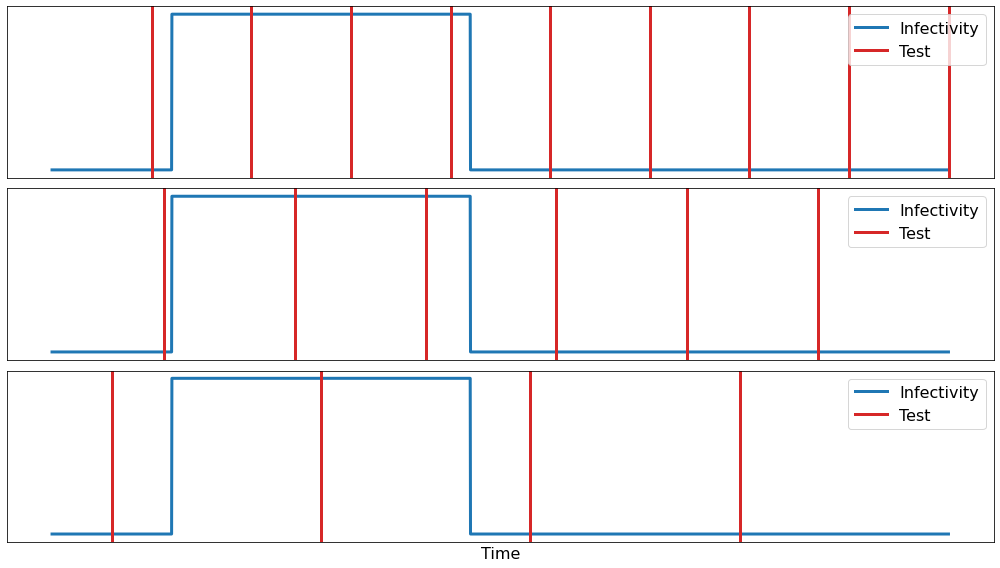

In [11]:
### system charecteristics ###
#prevalence = 1e-3
#infect_treshold = 1e-3
#tolerance = 0.05

### proportion of symptomatic ###
s = 0.5
#r = 1 #0.85
true_rates = np.linspace(0.5, 1, 2)
print(true_rates)
### Static times, when not using the parametric distr. + threshold methods ###
T_I = 6.5
T_R = 1
t0 = 0

### threshold for LOD and scaling for viral load ###
Vscale, TH = 1e6, 1e4

### plot parameters (should be TI indep.?)###
plot_res = 320
max_x = 20
x = np.linspace(0.2, max_x, plot_res+1)

### test charecteristics ###
tpr_def_rap, tnr_def_rap = 0.75, 0.99
tpr_def_con, tnr_def_con = 0.8, 0.996


def plot_scen(ax, TI_start, TI_stop, a, amp=lambda a: a**0, n=lambda a, nmax=3: (a>nmax)*nmax + a*(a<=nmax)): 
    t_start, t_stop, t0 = 0, 30, 0
    tr = lambda a: (TI_stop - TI_start)/n(a)
    t_list = np.arange(t_start, t_stop, 0.01)
    tests_list = list(t_stop%tr(a) + k*tr(a) + t0 for k in range(int(t_stop/tr(a))))

    ax.plot(t_list, np.vectorize(lambda t: amp(a)*(TI_start < t < TI_stop))(t_list), color="tab:blue", label="Infectivity")
    [ax.axvline(test, label="Test"*(test==tests_list[0]), color="tab:red") for test in tests_list]
    #ax.set_xlabel("Time")
    # ax.set_ylabel("Time")
    #ax.set_ylim(0, 10)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    ax.legend(loc="upper right")

fig, ax = plt.subplots(3,1, figsize=(14,8), tight_layout=True, sharex=True)
plot_scen(ax[0], 4, 14, 21/7)
plot_scen(ax[1], 4, 14, 16/7)
plot_scen(ax[2], 4, 14, 10/7)
ax[2].set_xlabel("Time")
figuresave("testscheme")


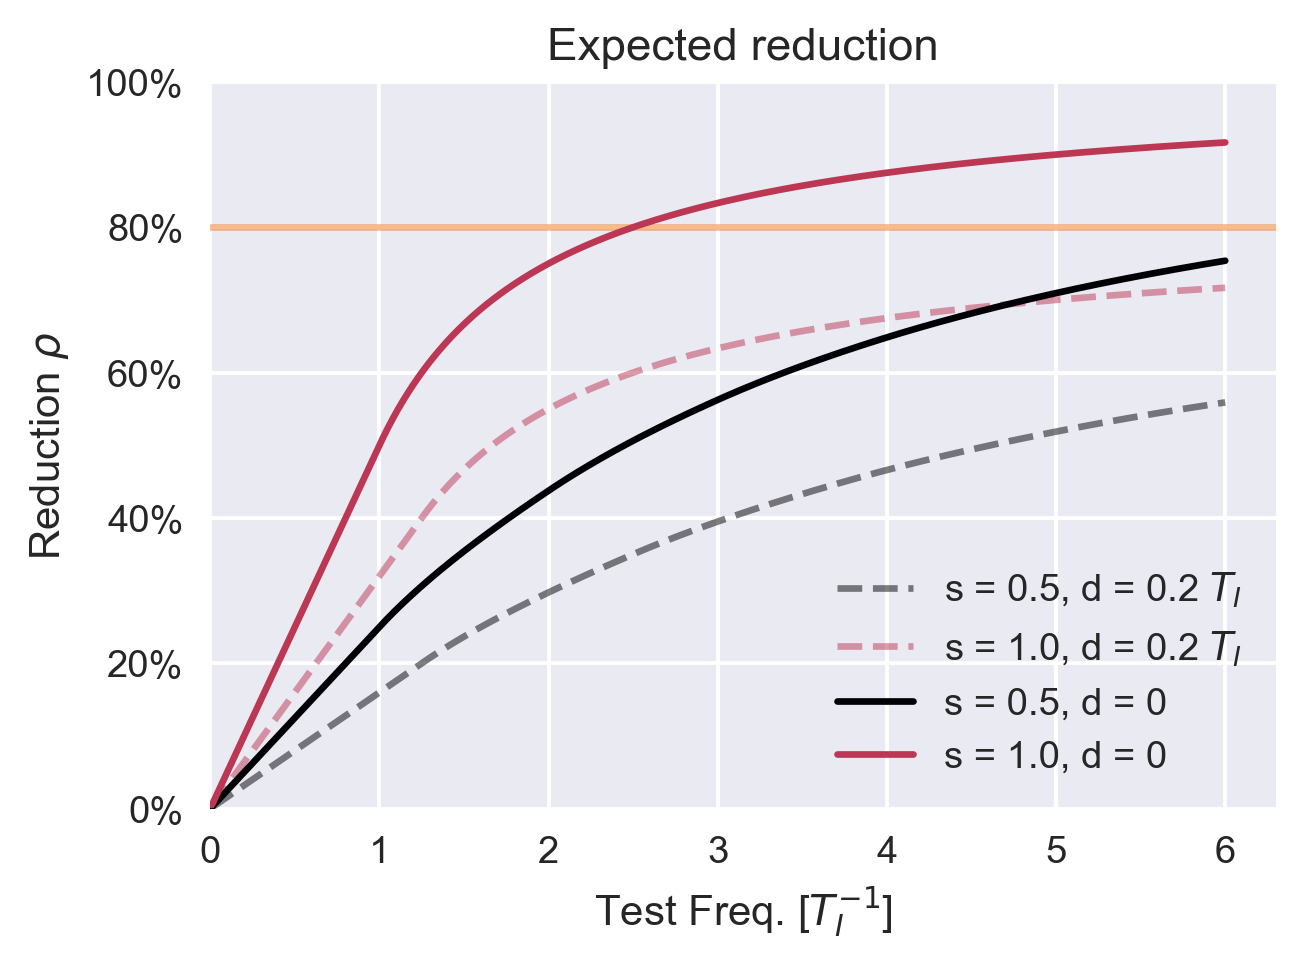

In [23]:
#%matplotlib inline

from matplotlib.ticker import FuncFormatter

fontsize=10

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : fontsize}


#mystyle = 'seaborn-notebook'
mystyle = 'seaborn'

# bmh is quite good somehow, but maybe too heavy
plt.style.use(mystyle)
plt.rc('font', **font)
#plt.style.use("ggplot")

#plt.figure(figsize=(5, 4), dpi=175)
fig, ((ax)) = plt.subplots(1, 1, dpi=275, figsize=(5,3.5))

#ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

cm = plt.cm.get_cmap('inferno')
#cm = plt.cm.get_cmap('Set1')
#cm = plt.cm.get_cmap('YlGnBu_r')

#dcol = 0.25
#col0 = 0.0

#dcol=0.2
#dcol = 0.25
dcol = 0.25
#col0=-dcol+0.05
col0 = 0

#t = np.array(range(len(I_noss_hi)))/48
#t_coarse = np.array(range(len(I_noss_lo)))/48

#plt.plot(t, I_noss_hi+E_noss_hi, color=cm(col0 + 3*dcol), alpha=0.3)

# Set colours:
# Normal order
col_multipliers = [1, 2, 2.8]
# Reversed order:
col_reversed = True
if col_reversed:
    col_multipliers = list(reversed(col_multipliers))
col1 = cm(col0 + col_multipliers[0]*dcol)
col2 = cm(col0 + col_multipliers[1]*dcol)
col3 = cm(col0 + col_multipliers[2]*dcol)



def cond_prob(tpr_in, tnr_in, infect_state, VL=1, accuracy=20):
    """
        Generate conditional probabilities, given true infectious state.
        Note that TPR and TNR can be functionalized by using evaluated functions as input.
    """
    return infect_state*round(tpr_in*VL, accuracy) + (not infect_state)*round(1 - tnr_in, accuracy)
    
def Nqr(time_between_tests, duration_of_infectiousness):
    N = duration_of_infectiousness/time_between_tests
    return N, int(N), N%1
    
def prob_repeated_test(infect_state, TR, TI, tpr_set=tpr_def_rap, tnr_set=tnr_def_rap, VL=1, d=0):
    """
        Returns the probability of returning true from repeated (rapid) tests, given true state.
        TODO: This may need to be modified to accomodate time dependent pos. and neg. rates
    """
    N, q, r = Nqr(TR, TI-d)
    
    tpr, fpr = cond_prob(tpr_set, tnr_set, True, VL=VL), cond_prob(tpr_set, tnr_set, False, VL=VL)
    fnr, tnr = 1 - tpr, 1 - fpr
    
    rate = int(infect_state)*fnr + int(not infect_state)*tnr
    return 1 - ((1-r)*rate**(q) + r*rate**(q+1))

def get_infect_interval(funct, threshold):
    """
        Returns infectious interval from unimodal distribution, given infectivity treshold
    """
    max_x = optimize.fmin(lambda t: -funct(t), 0, disp=False)[0]
    assert threshold<funct(max_x), f"Warning: Threshold incompat. w funct: legal theshold interv. [0, {funct(max_x)}]"
    ti_start = optimize.brentq((lambda t: funct(t)-threshold), 0, max_x, full_output=False)
    ti_stop = optimize.brentq(lambda t: funct(t)-threshold, max_x, max_x+100, full_output=False)
    return ti_start, ti_stop


def riemann_sum(funct, a, b, resolution=150):
    delta = (b-a)/resolution
    x = np.linspace(a,b-delta,resolution)
    return sum(funct(t)*delta for t in x)

def prod(l):
    ret = 1
    for i in l:
        ret = ret*i
    return ret

def ETD_given_D_repeated_test(infect_state, TR, TI, tpr_set=tpr_def_rap, tnr_set=tnr_def_rap, VL=1, d=0, prob_div=False):
    """
        Return: Expected Time of Detection, given Detection occours and true state
    """
    N, q, r = Nqr(TR, TI-d)
    fnr = 1 - cond_prob(tpr_set, tnr_set, True, VL=VL)
    
    #ETD_and_D = ((1/2 + fnr/(1-fnr))*(1-fnr**q)+ ((q+r/2)*(1-fnr) - q)*(fnr**q))*TR
    ETD_and_D = (sum(list((k+1/2)*fnr**(k) for k in range(q))) + r*(q + r/2)*fnr**(q))*(1-fnr)*TR
    prob_detect = (not prob_div) + (prob_div)*prob_repeated_test(infect_state, TR, TI, tpr_set=tpr_set, tnr_set=tnr_set, d=d)
    return ETD_and_D/prob_detect + d


def ETD_repeated_test(infect_state, TR, TI, tpr_set=tpr_def_rap, tnr_set=tnr_def_rap, d=0):
    """
        Return expected detection time, given true state
    """
    exp_time_detect = ETD_given_D_repeated_test(infect_state, TR, TI, tpr_set=tpr_set, tnr_set=tnr_set, d=d)
    prob_no_detect = (1-prob_repeated_test(infect_state, TR, TI, tpr_set=tpr_set, tnr_set=tnr_set, d=d))
    return exp_time_detect + prob_no_detect*(TI-d)

x = np.linspace(0.01, 1e2, int(1e4))
win_max=600
delay = 0.2
color = plt.cm.inferno(np.linspace(0, 1, len(true_rates)+1))

### Expected detection time for spectrum of parameters (sensitivity) ###
#fig, ax = plt.subplots(figsize=(16,8))
for i, j in enumerate(true_rates):
    z = 1 - np.vectorize(ETD_repeated_test)(True, 1/x, 1, tpr_set=j, tnr_set=tnr_def_rap, d=delay)
    ax.plot(x[:win_max], z[:win_max], label=f"s = {round(j,2)}, d = 0.2 $T_{{I}}$", color=color[i], 
            linestyle="--", alpha=0.5)
ax.axhline(1-delay, #label=f"Saturation at delay {delay}$T_{{I}}$", 
           color=col1, alpha=0.5)

for i, j in enumerate(true_rates):
    y = 1 - np.vectorize(ETD_repeated_test)(True, 1/x, 1, tpr_set=j, tnr_set=tnr_def_rap, d=0)
    ax.plot(x[:win_max], y[:win_max], label=f"s = {round(j,2)}, d = 0", color=color[i])

ax.set_ylim(0, 1)
ax.set_xlim(left=0)

ax.set_xlabel("Test Freq. [$T_{{I}}^{-1}$]")
ax.set_ylabel("Reduction $\\rho$")
ax.set_title("Expected reduction")
ax.legend(ncol=1, loc="lower right")

figuresave("reduction")


In [13]:
nu = 1/4.7

meanw = 7
cut = int((meanw-1)/2)

T_conf = df_ag_pr_day.loc[df_ag_pr_day.Date.isin(all_dates), "AGpos_PCRkonf"].values
P_conf = df_ag_pr_day.loc[df_ag_pr_day.Date.isin(all_dates), "AGpos_PCRpos"].values

T_obs = df_pcr.loc[date_range, "NotPrevPos"].values
T_pcr = T_obs-T_conf
T_ag = df_ag.loc[date_range, "NotPrevPos"].values
T_ref = 30000

P_obs = df_pcr.loc[date_range, "NewPositive"].values
P_pcr = P_obs-P_conf
P_ag = df_ag.loc[date_range, "NewPositive"].values

loss = lambda x: (x)**2
cost = lambda beta, P=P_pcr, T=T_pcr: np.sum(loss(P[cut:-cut] - (T[cut:-cut]**beta)*rnMean(P/(T**beta), meanw)))

betas_tmp = np.arange(0, 1, 0.01)
cost_list = [cost(b) for b in betas_tmp]

beta_optimal = betas_tmp[cost_list.index(min(cost_list))]
print("Optimal beta: ", beta_optimal)
beta = beta_optimal

P_ref1 = P_pcr*(T_ref/T_pcr)**beta
print("P_ref, Method 1: ", P_ref1)


I = lambda beta=beta_optimal, P=P_pcr, T=T_pcr: P/(T**beta)
r = lambda I: np.diff(np.log(I))
#Re = lambda I, nu=nu: (1/nu)*np.diff(I)/I[:-1] + 1
Re = lambda I, nu=nu: r(I)/nu  + 1

# P=IT^beta

#I_pcr = I(P=P_pcr, T=T_pcr)
#I_tot = I(P=P_tot, T=T_tot)

#sig_I = np.std(r(I(P=P_pcr, T=T_pcr)))
#sig_r = np.std(np.diff(r(I(P=P_pcr, T=T_pcr))))
#tau = sig_I/sig_r

#print("sig_I: ", sig_I)
#print("sig_I: ", sig_r)
#print("tau: ", tau)
#print("cv_I: ", sig_I/np.mean(r(I(P=P_pcr, T=T_pcr))))
#print("cv_r: ", sig_r/np.mean(np.diff(r(I(P=P_pcr, T=T_pcr)))))




Optimal beta:  0.38
P_ref, Method 1:  [270.29900688 249.63425624 195.85514625 217.48891985 272.6601824
 307.52783364 290.27845828 320.01198506 255.0166449  232.05969121
 302.53216029 312.30750119 306.20480785 284.21810531 315.14124187
 316.48690063 306.58050629 356.76930389 352.22723699 283.73311989
 247.87748255 264.65082818 269.40246522 266.21657935 297.45875604
 371.51171854 323.40258975 282.93405227 363.80798893 325.15775893
 298.62717686 403.67810257 376.17582784 425.93277276 316.24166707
 349.31521902 383.31755857 334.64236404 411.71272389 491.00648126
 401.93469121 356.4020455  343.91153684 426.11762505 346.4741808
 422.8753986  464.63654393 457.60067414 353.5985029  307.56144229
 366.86059256 362.65515029 367.40812847 413.88438797 512.82845871
 360.73483444 378.20047789 406.96941216 343.90422635 392.73984171]


0.16631362068965516
[0.0888219  0.10058324 0.12978078 0.14018317 0.16176428 0.13764436
 0.14977279 0.13462988 0.11822931 0.12038888 0.15881948 0.14855079
 0.14229493 0.15620045 0.13077021 0.11130897 0.11886624 0.15562267
 0.1472591  0.14638474 0.1744956  0.14106321 0.10946381 0.11993833
 0.15100371 0.13993845 0.14494962 0.17680833 0.10678805 0.10277847
 0.11916688 0.14879714 0.13893848 0.15378076 0.1832611  0.15689653
 0.11395069 0.12817143 0.16415317 0.15467457 0.17380114 0.14071152
 0.13170129 0.10977417 0.13283578 0.15925626 0.14044005 0.13821484
 0.16830781 0.14579076 0.08896209 0.10549555 0.1170219  0.1345059
 0.11942538 0.15800833 0.1204375  0.07446988 0.09733862 0.11759724] [0.04441095 0.05029162 0.06489039 0.07009159 0.08088214 0.06882218
 0.0748864  0.06731494 0.05911466 0.06019444 0.07940974 0.0742754
 0.07114747 0.07810022 0.0653851  0.05565448 0.05943312 0.07781134
 0.07362955 0.07319237 0.0872478  0.0705316  0.05473191 0.05996916
 0.07550185 0.06996922 0.07247481 0.0884041

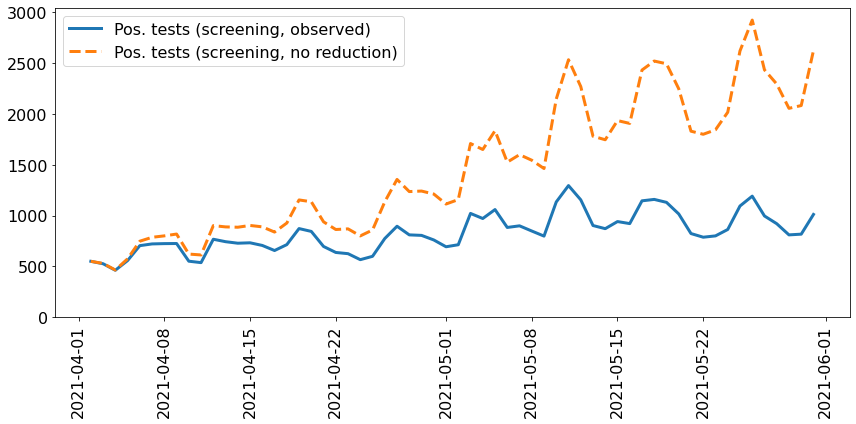

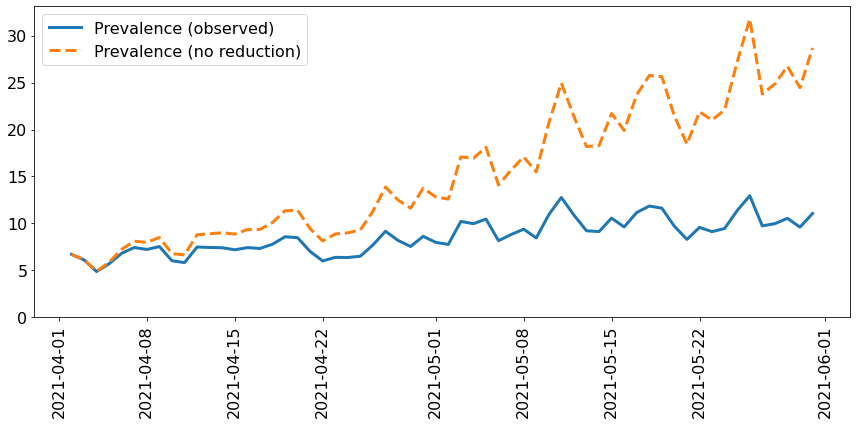

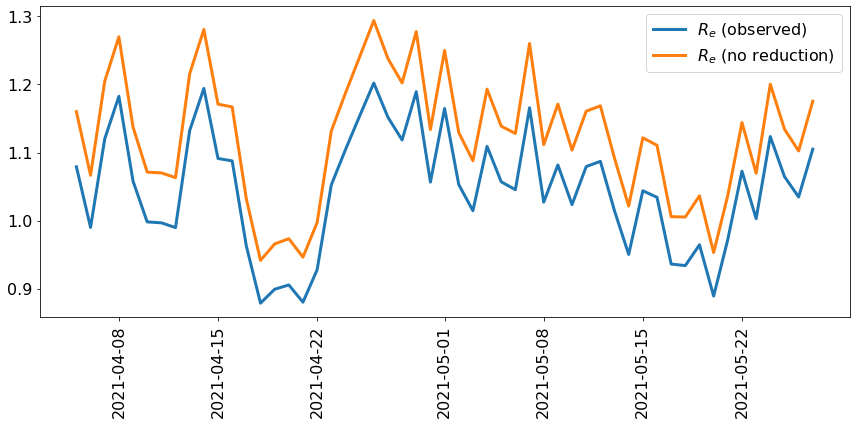

In [14]:
T_tmp = T_pcr + T_conf #- T_ref
P_tmp = P_pcr + P_conf #- P_ref1


pop = 5.8e6
N_hom = (1/nu)*(T_tmp)/pop
N_het = 3
comply_het = lambda N: ((T_tmp)/N)/pop
compy_hom = 1

print(max([sum(T_obs[i:i+5])/pop for i in range(len(T_obs)-5)]))

rho_het_min = comply_het(4)*(1-ETD_repeated_test(True, 1/4, 1, tpr_set=j, tnr_set=tnr_def_rap, d=0))
rho_het_max = comply_het(2)*(1-ETD_repeated_test(True, 1/2, 1, tpr_set=j, tnr_set=tnr_def_rap, d=0))
rho_hom = 1-np.vectorize(ETD_repeated_test)(True, 1/N_hom, 1, tpr_set=j, tnr_set=tnr_def_rap, d=0)

print(N_hom, rho_hom)

I_contrafact = lambda I0, rs: np.array([(I0*np.exp(r)) for r in np.cumsum([0] + list(rs))])
I_cf = I_contrafact(I(P=P_tmp, T=T_tmp)[0], nu*(Re(I(P=P_tmp, T=T_tmp))*(1/(1-rho_hom))[:-1] - 1))

if True:
    
    fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
    ax.plot(all_dates, P_tmp, label="Pos. tests (screening, observed)")
    ax.plot(all_dates, I_cf*((T_tmp)**beta), label="Pos. tests (screening, no reduction)", alpha=1, linestyle="--")
    ax.set_ylim(bottom=0)
    plt.xticks(rotation=90)
    ax.legend()
    figuresave("exp_pos_tests")

    print(sum(I_cf*((T_tmp)**beta) - P_tmp)/sum(I_cf*((T_tmp)**beta))) 
    print(sum(I_cf*((T_tmp)**beta) - P_tmp)/sum(P_tmp))
    
    fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
    ax.plot(all_dates, I(P=P_tmp, T=T_tmp), label="Prevalence (observed)")
    ax.plot(all_dates, I_cf, label="Prevalence (no reduction)", alpha=1, linestyle="--")
    ax.set_ylim(bottom=0)
    plt.xticks(rotation=90)
    ax.legend()
    figuresave("prevalence")

    fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
    #ax.plot(rnTime(all_dates[:-1], 7), rnMean(Re(I(beta)), 7), label="reproductions via Re")
    #ax.plot(rnTime(all_dates[:-1], 7), rnMean((1/(1-rho_hom))[:-1]*Re(I(beta)), 7), label="$R_{{Hom}}$ (via Re)")
    ax.plot(rnTime(all_dates[:-1], 7), rnMean((r(I(P=P_tmp, T=T_tmp)))/nu+1, 7), label="$R_{{e}}$ (observed)")
    ax.plot(rnTime(all_dates[:-1], 7), rnMean((1/(1-rho_hom))[:-1]*((r(I(P=P_tmp, T=T_tmp)))/nu+1), 7), 
            label="$R_{{e}}$ (no reduction)")
    plt.xticks(rotation=90)
    ax.legend()
    figuresave("contact_nrs")

    #fig, ax = plt.subplots(figsize=(12,6))
    #ax.plot(np.diff(I_cf*((T_tmp)**beta)) - np.diff(P_tmp))

In [15]:
if 0:
    fig, ax = plt.subplots()
    ax.plot(all_dates[:-1], r(I(P=P_tmp, T=T_tmp))/nu+1, label="reproductions via rs", alpha=0.4)
    ax.plot(all_dates[:-1], Re(I(P=P_tmp, T=T_tmp)), label="reproductions via Re", alpha=0.4)
    plt.xticks(rotation=90)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', va='top')
    ax.legend()

    fig, ax = plt.subplots()
    ax.plot(betas_tmp, cost_list)
    ax.set_xlabel("$\\beta$")
    ax.set_ylabel("sum of sqare of differences for $P(t)$")
    
    fig, ax = plt.subplots()
    ax.plot(all_dates[cut:-cut], (P_tmp)[cut:-cut], label="Pt - data")
    ax.plot((all_dates[cut:-cut], (T_tmp)[cut:-cut]**beta)*rnMean(I(P=P_tmp, T=T_pcr), meanw), 
            label="Pt - optimized smoothed estimate")
    plt.xticks(rotation=90)
    ax.legend()

if 0:
    fig, ax = plt.subplots()
    ax.plot(all_dates[cut:-cut], P_pcr[cut:-cut] - (T_pcr[cut:-cut]**beta)*rnMean(I(P=P_pcr, T=T_pcr), meanw), label="residuals")
    plt.xticks(rotation=90)
    ax.legend()

    fig, ax = plt.subplots()
    ax.plot(all_dates, df_ag.loc[date_range, "NotPrevPos"].values + df_pcr.loc[date_range, "NotPrevPos"].values, label="residuals")
    ax.legend()



In [9]:
if False:
    fig, ax = plt.subplots()
    ax.plot(all_dates, T)

    Tshift = np.roll(T, 7)
    Pshift = np.roll(P, 7)

    fig, ax = plt.subplots()
    ax.plot(all_dates, ((P/Pshift)*(T/Tshift)**0.25 - 1)*4.7/7+1)
    ax.plot(all_dates, ((P/Pshift)*(T/Tshift)**0.55 - 1)*4.7/7+1)
    ax.fill_between(all_dates, ((P/Pshift)*(T/Tshift)**0.55 - 1)*4.7/7+1, 1, alpha=0.2)


In [10]:
if False:
    fig, ax = plt.subplots()
    ax.plot(all_dates[:-1], r(I_tot)/nu +1)
    ax.plot(all_dates[:-1], Re(I_tot))
    plt.xticks(rotation=90)

    #ax.set_ylim(0.7, 1.3)

    fig, ax = plt.subplots()
    ax.plot(rnTime(all_dates[:-1], 7), rnMean(r(I_tot)/nu+1, 7))
    ax.plot(rnTime(all_dates[:-1], 7), rnMean(Re(I_tot), 7))
    plt.xticks(rotation=90)

    #ax.set_ylim(0.7, 1.3)

